In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
sns.set_style(style='white')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

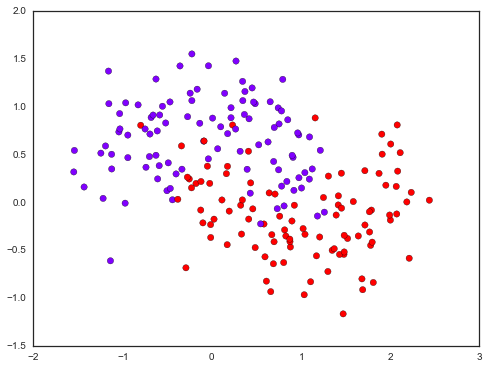

In [28]:
from sklearn import datasets
np.random.seed(0)
X, y = datasets.make_moons(n_samples=200, noise=0.3)
plt.scatter(X[:,0],X[:,1], s=40, c = y, cmap=plt.cm.rainbow);

In [29]:
def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.rainbow)

In [30]:
np.random.randint(len(X),size=batch_size)

NameError: name 'batch_size' is not defined

In [31]:
np.random.randint(50,size=5)

array([ 8, 10,  5, 38, 38])

In [32]:
a = np.array([[1,2],[2,3],[4,5],[5,6]])
a

array([[1, 2],
       [2, 3],
       [4, 5],
       [5, 6]])

In [106]:
np.mean(a, axis = 0)

array([ 3.,  4.])

In [119]:
from collections import defaultdict

class NeuralNet(object):
    def __init__(self, input_dim, output_dim):
        self.nn_input_dim = input_dim # input layer dimensionality
        self.nn_output_dim = output_dim # output layer dimensionality
    
    def scale_fit(self, X):
        """
        Record mean and standard deviation of input data per features
        """
        self.mean = np.mean(X, axis = 0)
        self.std = np.std(X, axis = 0, ddof=1)
    
    def scale_transform(self, X):
        """
        Apply scaling transform
        """
        return (X - self.mean) / self.std
    
    def forward_prop(self, X):
        """
        Forward propagation to calculate output probabilities
        """
        W1, b1, W2, b2 = self.model['W1'], self.model['b1'], self.model['W2'], self.model['b2']

        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return probs, a1
        
    
    def calculate_loss(self, X):
        """
        function to evaluate the total loss on the dataset
        """
        probs, _ = self.forward_prop(X)
    
        # Calculating the loss
        corect_logprobs = -np.log(probs[range(self.num_examples), y])
        data_loss = np.sum(corect_logprobs)
        
        W1, b1, W2, b2 = self.model['W1'], self.model['b1'], self.model['W2'], self.model['b2']
        
        # Add regulatization term to loss
        data_loss += self.reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
        return 1./self.num_examples * data_loss
    
    def predict(self, X):
        """
        Function predicts class label based on output probabilities
        """
        if self.scale:
            X = self.scale_transform(X)
            
        probs, _ = self.forward_prop(X)
        return np.argmax(probs, axis=1)
    
    def build_model(self, X, y, nn_hdim, epsilon = 0.01, reg_lambda = 0.01, num_passes = 10000, print_loss = False,
                    stochastic_mini_batch_size = None, scale = False):
        """
        function initializes parameters and performs backpropagation and batch gradient descent
        """
        self.scale = scale
        self.num_examples = len(X)
        self.reg_lambda = reg_lambda
        
        # Initialize the parameters to random values
        np.random.seed(0)
        W1 = np.random.randn(self.nn_input_dim, nn_hdim) / np.sqrt(self.nn_input_dim)
        b1 = np.zeros((1, nn_hdim))
        W2 = np.random.randn(nn_hdim, self.nn_output_dim) / np.sqrt(nn_hdim)
        b2 = np.zeros((1, self.nn_output_dim))

        # Learned model parmeters
        self.model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'loss': []}
        
        # input scaling
        if self.scale:
            self.scale_fit(X)
            X = self.scale_transform(X)
            
        # Gradient descent
        for i in xrange(0, num_passes):
            
            idx = range(self.num_examples)
            
            # stochastic mini batch sampling
            if stochastic_mini_batch_size != None and stochastic_mini_batch_size <= self.num_examples:
                idx = np.random.randint(self.num_examples, size=stochastic_mini_batch_size)
            
            probs, a1 = self.forward_prop(X[idx,:])
            
            W1, b1, W2, b2 = self.model['W1'], self.model['b1'], self.model['W2'], self.model['b2']
            
            # Backpropagation
            delta3 = probs
            delta3[range(len(idx)), y[idx]] -= 1
            dW2 = (a1.T).dot(delta3)
            db2 = np.sum(delta3, axis=0, keepdims=True)
            delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
            dW1 = np.dot(X[idx,:].T, delta2)
            db1 = np.sum(delta2, axis=0)

            # Add regularization terms
            dW2 += reg_lambda * W2
            dW1 += reg_lambda * W1

            # Gradient descent parameter update
            W1 += -epsilon * dW1
            b1 += -epsilon * db1
            W2 += -epsilon * dW2
            b2 += -epsilon * db2


            # Assign new parameters to model
            self.model['W1'], self.model['b1'], self.model['W2'], self.model['b2'] = W1, b1, W2, b2

            # store loss value every 500 iterations
            if i % 500 == 0:
                loss = self.calculate_loss(X)
                self.model['loss'].append(loss)
                if print_loss:
                    print "Loss after iteration %i: %f" %(i, loss)


        return self.model

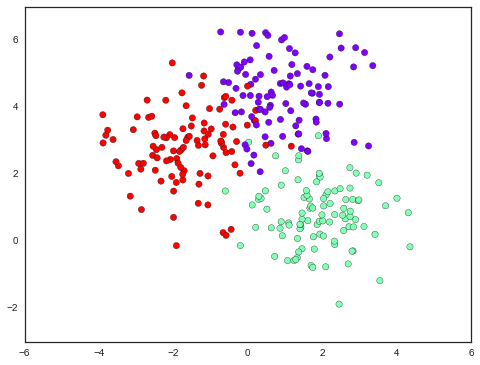

In [120]:
np.random.seed(0)
X, y = datasets.make_blobs(n_samples= 300, n_features=2, centers=3)
plt.scatter(X[:, 0], X[:, 1], marker='o', s=40, c=y, cmap=plt.cm.rainbow)

Train Accuracy:  0.93


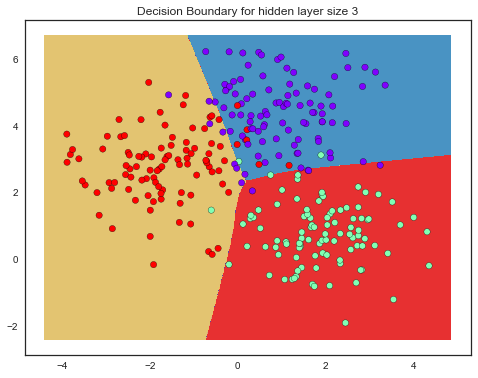

In [121]:
NN = NeuralNet(input_dim = 2, output_dim = 3)
model = NN.build_model(X, y, 3, epsilon=0.01, reg_lambda= 0.5, num_passes=5000, stochastic_mini_batch_size=None)

print "Train Accuracy: ",np.mean(NN.predict(X) == y)
# Plot the decision boundary
plot_decision_boundary(lambda x: NN.predict(x), X, y)
plt.title("Decision Boundary for hidden layer size 3");

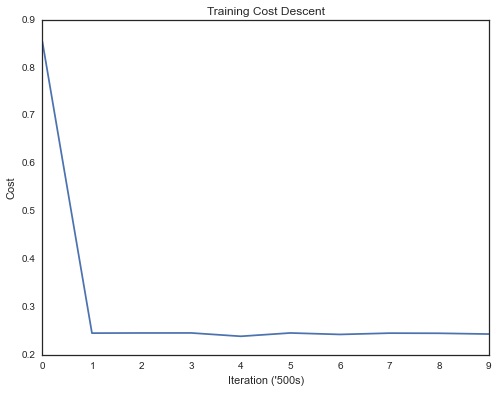

In [113]:
# Check if your model reached convergence
plt.plot(xrange(len(model['loss'])), model['loss'])
plt.xlabel("Iteration ('500s)")
plt.ylabel("Cost")
plt.title("Training Cost Descent");

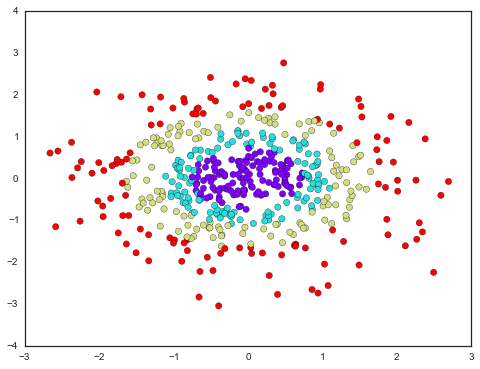

In [84]:
np.random.seed(0)
X, y = datasets.make_gaussian_quantiles(n_samples=500, n_features=2, n_classes=4)
plt.scatter(X[:, 0], X[:, 1], marker='o', s=40, c=y, cmap=plt.cm.rainbow)

Train Accuracy:  0.835


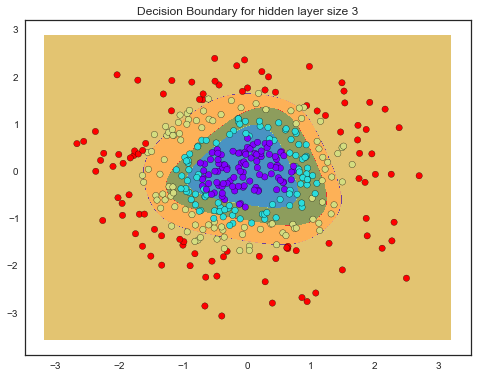

In [92]:
np.random.seed(0)
X, y = datasets.make_gaussian_quantiles(n_samples=400, n_features=2, n_classes=4)

NN = NeuralNet(input_dim = 2, output_dim = 4)
model = NN.build_model(X, y, 3, epsilon=0.001, reg_lambda= 1, num_passes=10000, stochastic_mini_batch_size=None)

print "Train Accuracy: ",np.mean(NN.predict(X) == y)
# Plot the decision boundary
plot_decision_boundary(lambda x: NN.predict(x), X, y)
plt.title("Decision Boundary for hidden layer size 3");

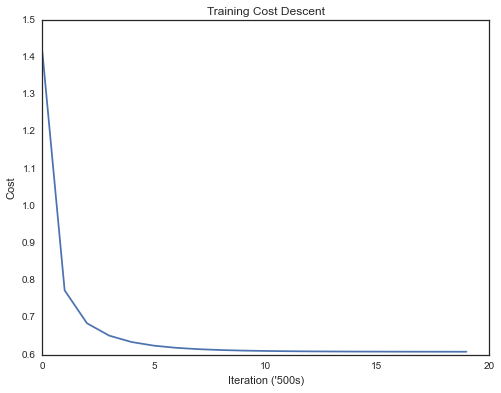

In [93]:
# Check if your model reached convergence
plt.plot(xrange(len(model['loss'])), model['loss'])
plt.xlabel("Iteration ('500s)")
plt.ylabel("Cost")
plt.title("Training Cost Descent");

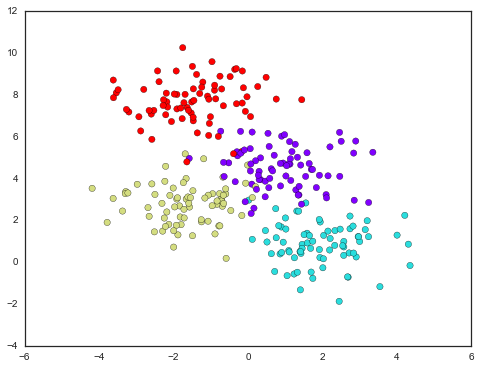

In [114]:
np.random.seed(0)
X, y = datasets.make_blobs(n_samples= 300, n_features=2, centers=4)
plt.scatter(X[:, 0], X[:, 1], marker='o', s=40, c=y, cmap=plt.cm.rainbow)

Train Accuracy:  0.936666666667


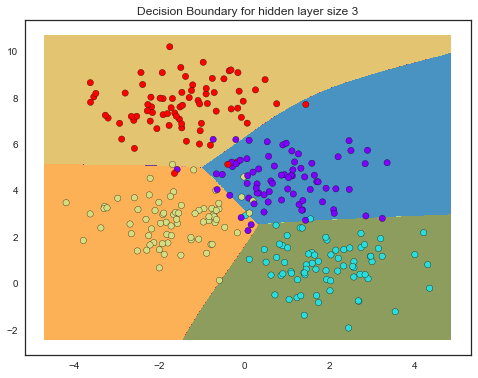

In [118]:
np.random.seed(0)
X, y = datasets.make_blobs(n_samples= 300, n_features=2, centers=4)

NN = NeuralNet(input_dim = 2, output_dim = 4)
model = NN.build_model(X, y, 4, epsilon=0.005, reg_lambda= 5, num_passes=5000, scale=True)

print "Train Accuracy: ",np.mean(NN.predict(X) == y)
# Plot the decision boundary
plot_decision_boundary(lambda x: NN.predict(x), X, y)
plt.title("Decision Boundary for hidden layer size 3");

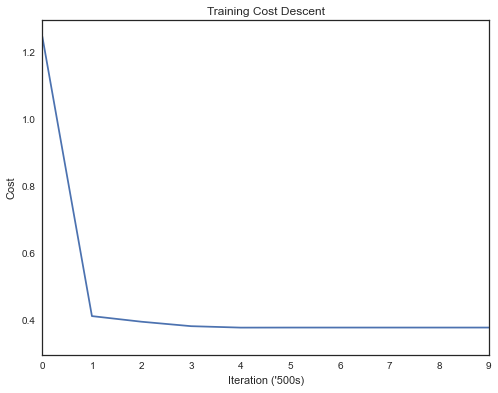

In [96]:
# Check if your model reached convergence
plt.plot(xrange(len(model['loss'])), model['loss'])
plt.xlabel("Iteration ('500s)")
plt.ylabel("Cost")
plt.title("Training Cost Descent");

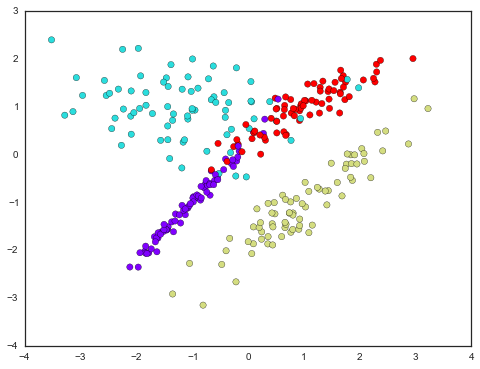

In [97]:
np.random.seed(6)
X, y = datasets.make_classification(n_samples=300, n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1, n_classes=4)
plt.scatter(X[:, 0], X[:, 1], marker='o', s=40, c=y, cmap=plt.cm.rainbow)

Train Accuracy:  0.926666666667


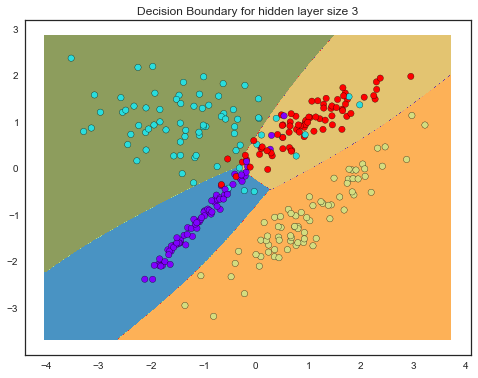

In [104]:
np.random.seed(6)
X, y = datasets.make_classification(n_samples=300, n_features=2, n_redundant=0, n_informative=2,
                                     n_clusters_per_class=1, n_classes=4)

NN = NeuralNet(input_dim = 2, output_dim = 4)
model = NN.build_model(X, y, 5, epsilon=0.005, reg_lambda= 2, num_passes=10000, stochastic_mini_batch_size=200)

print "Train Accuracy: ",np.mean(NN.predict(X) == y)
# Plot the decision boundary
plot_decision_boundary(lambda x: NN.predict(x), X, y)
plt.title("Decision Boundary for hidden layer size 3");

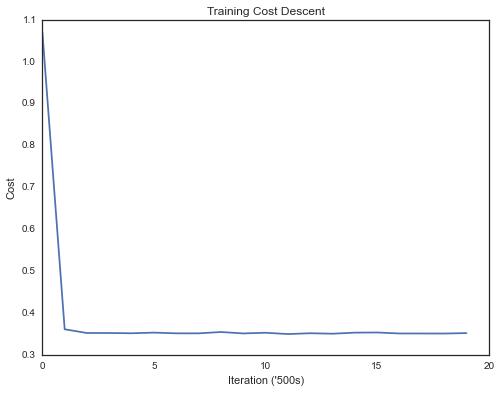

In [105]:
# Check if your model reached convergence
plt.plot(xrange(len(model['loss'])), model['loss'])
plt.xlabel("Iteration ('500s)")
plt.ylabel("Cost")
plt.title("Training Cost Descent");